In [22]:
import operator 
from typing import TypedDict, List, Annotated

In [23]:
print("subosijdk")

subosijdk


In [24]:
from __future__ import annotations

import operator
from typing import TypedDict, List, Annotated

from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage

In [25]:
class Task(BaseModel):
    id : int
    title : str
    brief : str = Field(..., description="What to cover")

In [26]:
class Plan(BaseModel):
    blog_title : str
    tasks : List[Task]


In [27]:
class State(TypedDict):
    toipc : str
    plan : Plan
    sections : Annotated[List[str], operator.add]
    final : str

In [28]:
llm = ChatOpenAI(model="gpt-4.1-mini")

In [29]:
def orchestrator(state: State) -> dict:
    plan = llm.with_structured_output(plan).invoke(
        [
            SystemMessage(content = (
            "Create a blog plan with 5-7 sections on the following topic."
        )),
        HumanMessage(content =f"Topic: {state['topic']}")
        ]
    )
    return {"Plan": plan}

In [30]:
def fanout(state: State):
    return [
        Send(
            "worker", 
                {
                 "task": task, 
                 "topic": state["topic"], 
                 "plan": state["plan"]
                }
            )
            for task in state["plan"].tasks
            ]

In [31]:
def worker(payload: dict) -> dict:

    # payload contains what we sent
    task = payload["task"]
    topic = payload["topic"]
    plan = payload["plan"]

    blog_title = plan.blog_title

    section_md = llm.invoke(
        [
            SystemMessage(content="Write one clean Markdown section."),
            HumanMessage(
                content=(
                    f"Blog: {blog_title}\n"
                    f"Topic: {topic}\n\n"
                    f"Section: {task.title}\n"
                    f"Brief: {task.brief}\n\n"
                    "Return only the section content in Markdown."
                )
            ),
        ]
    ).content.strip()

    return {"sections": [section_md]}

In [32]:
from pathlib import Path

def reducer(state: State) -> dict:
    
    title = state["plan"].blog_title
    body = "\n\n".join(state["sections"]).strip()

    final_md = f"# {title}\n\n{body}\n"

    # ---- save to file ----
    filename = title.lower().replace(" ", "_") + ".md"
    output_path = Path(filename)
    output_path.write_text(final_md, encoding="utf-8")

    return {"final": final_md}


In [33]:
g = StateGraph(State)
g.add_node("orchestrator", orchestrator)
g.add_node("worker", worker)
g.add_node("reducer", reducer)

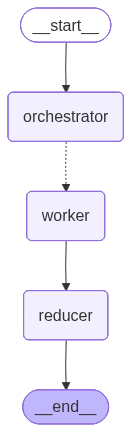

In [34]:
g.add_edge(START, "orchestrator")
g.add_conditional_edges("orchestrator", fanout, ["worker"])
g.add_edge("worker", "reducer")
g.add_edge("reducer", END)

app = g.compile()

app

In [35]:
out = app.invoke({"topic": "Write a blog on Self Attention", "sections": []})

UnboundLocalError: cannot access local variable 'plan' where it is not associated with a value